# Part I- Preparation of data and environment

** If you are planning to use google drive as your main drive you should mount google drive into the code here. otherwise you need to change the path to files and folders accordingley- 
Run this and you will be asked to enter a password which is gnerated by the gDrive, copy and paste it in the box then hit the enter btton. Wait for a few seconds and your drive is mounted and ready to use. To navigate through gdrive and make folders and upload files click the 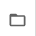 icon on the leftside panel and navigate to the folder you want to use with this code. **

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Now that the drive is ready you can upload or download all the necessary files into/from the drive. Please note that you migth need to mount drive whenever you close the notebook. **


After getting the drive ready we need to implement the required python 
environment for the analysis. We do so by importing main packages like pandas, seaborn, matlib and numpy. Please note that later through the code we would also import other packages as required.

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Here we have to address all the files and folders we need for this analysis. First we should determine the path to the directory name. We also need a folder for the location of data and two file names for RNAseq and Clinical data, both in the text format. We could also make a folder for depositing the results including csv, tsv or image files. Please note that you have to make these folders in your gDrive and give the path to the folders here.

In [3]:
notebook_path = os.path.dirname("/content/drive/MyDrive/Colab_Notebooks/melanoma/")
# get the path for the TCGA data
location_of_data = "/content/drive/MyDrive/Colab_Notebooks/melanoma/"
rna_file_name = "data_RNA_Seq_v2_expression_median.txt"
clinical_file_name ="data_clinical_patient.txt"
# get the path for the provisional data
location_of_data2 = "/content/drive/MyDrive/Colab_Notebooks/melanoma/"
rna_file_name2 = "pdata_RNA_Seq_v2_expression_median.txt"
clinical_file_name2 ="pdata_bcr_clinical_data_patient.txt"

You could use differnt commands to check that everything is ready to use and all folders and files are understandable for this code. 
-----------------------------------------------------------------------------





In [4]:
location_of_data

'/content/drive/MyDrive/Colab_Notebooks/melanoma/'

In [5]:
rna_file_name

'data_RNA_Seq_v2_expression_median.txt'

This is a general function for reading the contents of files. Instead of simpley providing and reading files one by one, we use this code to extract the contents of files. There are two such function in this code one for extracting RNA seq realted contents and one for the clinical files extraction.

In [6]:
def read_rna_file(location, name_file):
       
    rna_file_path = location + name_file
    try:
        rna = pd.read_csv(rna_file_path,  sep='\t')
        
        #to make sure we do not process the name of genes we will convert them to string
        rna[['Hugo_Symbol', 'Entrez_Gene_Id']] = rna[['Hugo_Symbol', 'Entrez_Gene_Id']].astype(str)
        
        # make first two columns as indexx of data frame 
        rna =  rna.set_index([ 'Hugo_Symbol','Entrez_Gene_Id']) 
        
    except:
        print("***************")
        print("the location of file is not correct, or two columns 'Hugo_Symbol', 'Entrez_Gene_Id' do not exist")
        print("***************")
    
    return rna

In [7]:
def read_clinical_file(location, name_file):
      
    clinical_file_path = location + name_file
    try:
        clinical_data = pd.read_csv(clinical_file_path,  sep='\t', skiprows=4)
        
        # make first the column PATIENT_ID as indexx of data frame 
        #clinical_data =  clinical_data.set_index([ 'PATIENT_ID']) 
        
    except:
        print("***************")
        print("the location of file is not correct, or the column '#Patient Identifier' does not exist")
        print("***************")
    
    return clinical_data

Extracting the contents of the files using the Pathes and the name of the files you have provided in the previous sections. After reading the files you migth want to write the contents on to csv files for later use in the comming steps. Please note that if you use the merged version writing into new files is not required.

In [8]:
#Reading files TCGA and provisional data sets
original_rna = read_rna_file(location_of_data, rna_file_name)
original_clinical = read_clinical_file(location_of_data, clinical_file_name)
provisional_rna = read_rna_file(location_of_data2, rna_file_name2)
provisional_clinical = read_clinical_file(location_of_data2, clinical_file_name2)
#Writing into csv files for later use
original_rna.to_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/moriginal_rna.csv")
original_clinical.to_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/moriginal_clinical.csv")
#check to see if everything is working
original_clinical.head()

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS,ETHNICITY,FORM_COMPLETION_DATE,HISTORY_NEOADJUVANT_TRTYN,ICD_10,ICD_O_3_HISTOLOGY,ICD_O_3_SITE,INFORMED_CONSENT_VERIFIED,NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,PERSON_NEOPLASM_CANCER_STATUS,PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT,PRIOR_DX,RACE,RADIATION_THERAPY,WEIGHT,CENTER,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS
0,TCGA-3N-A9WB,SKCM,SKCM,5564E6A7-2195-4B0D-994E-B0617B58E889,71.0,Male,STAGE IA,7TH,NaN,-26176,0.0,Not Hispanic Or Latino,5/29/14,No,C44.5,8720/3,C44.5,Yes,Yes,M0,NX,T1A,With Tumor,NaN,No,White,No,78.0,Greenville Health System,Yes,1:DECEASED,17.029950,1:DEAD WITH TUMOR,17.029950,NaN,NaN,1:PROGRESSION,14.005326
1,TCGA-3N-A9WC,SKCM,SKCM,551E071A-C290-4B48-9000-F64C2A44DFB7,82.0,Male,STAGE IIA,6TH,2022,-30286,0.0,Not Hispanic Or Latino,5/29/14,No,C77.3,8720/3,C77.3,Yes,No,M0,NX,T2B,With Tumor,NaN,No,White,No,68.0,Greenville Health System,Yes,0:LIVING,66.475984,0:ALIVE OR DEAD TUMOR FREE,66.475984,NaN,NaN,1:PROGRESSION,56.054180
2,TCGA-3N-A9WD,SKCM,SKCM,A29A20E3-5C2C-4F37-B93E-AE9EBC46EC53,82.0,Male,STAGE IIIA,7TH,NaN,-30163,0.0,Not Hispanic Or Latino,5/29/14,No,C77.0,8720/3,C77.0,Yes,Yes,M0,N1A,T2A,With Tumor,NaN,No,White,No,116.0,Greenville Health System,Yes,1:DECEASED,12.986159,1:DEAD WITH TUMOR,12.986159,NaN,NaN,1:PROGRESSION,10.060164
3,TCGA-BF-A1PU,NaN,SKCM,3DD5A206-D7F3-42F1-B9CC-4B31C76D495D,46.0,Female,STAGE IIC,7TH,387,-17025,0.0,NaN,4/25/13,No,C44.9,8720/3,C44.9,Yes,Yes,M0,N0,T4B,Tumor Free,NaN,No,White,No,58.0,Cureline,No,0:LIVING,12.723148,0:ALIVE OR DEAD TUMOR FREE,12.723148,NaN,NaN,1:PROGRESSION,15.912154
4,TCGA-BF-A1PV,NaN,SKCM,EFF78AF6-0F68-49B9-866B-0D511606F2B1,74.0,Female,STAGE IIC,7TH,14,-27124,0.0,NaN,4/25/13,No,C44.9,8720/3,C44.9,Yes,No,M0,N0,T4B,Tumor Free,NaN,No,White,No,70.0,Cureline,No,0:LIVING,0.460269,0:ALIVE OR DEAD TUMOR FREE,0.460269,NaN,NaN,0:CENSORED,0.460269


In [9]:
provisional_rna.head()

TCGA-3N-A9WB-06  ...  TCGA-Z2-AA3V-06
Hugo_Symbol  Entrez_Gene_Id                   ...                 
LOC100130426 100130426                0.0000  ...           0.0000
UBE2Q2P3     100133144                4.4709  ...           2.7530
             100134869                6.4338  ...           2.4783
LOC149767    10357                  143.5703  ...          29.0011
TIMM23       10431                 1224.5557  ...         514.6314

[5 rows x 472 columns]

In [10]:
# check if the number of columns and raws are correct in the dataframe
original_rna.shape

(20531, 443)

**This function is for Normalization of gene expression values.** Because the data obtained from differnt patients are non-homogenous, we need a strategy to normalize them before use. 
One such method would be Max-Min division, where after finding maximum level of expression for any gene in each patients, all values for that specefic patients would eb divided by this value. 
The reason behind this is that we need a way to scale all our data for the machine learning pipline. In some algorithms (e.g. k-NN, k-means) the weigth would be given to the gene with more expression. To prevent that we use max-division normalization. You could find mor on this in the refrences 1 and 2. 


1.   [Normalizations: dividing by maximum](https://stats.stackexchange.com/questions/413115/normalizations-dividing-by-maximum)
2.   [Max Normalization](https://www.sciencedirect.com/topics/computer-science/max-normalization)



In [11]:
def normalizing_patients(df_rna_values):
    
       
    #finding maximum level expression of genes for each patient
    Max_each_patient = df_rna_values.max(axis=0)
    
    #Divide the values of each gene by the maximum value of gene expression of the same patient
    df_normalized_rna_values = df_rna_values.divide(Max_each_patient, axis=1)
    
    return df_normalized_rna_values

In [12]:
#Run and check the normalization outputs
normalized_rna = normalizing_patients(original_rna)
normalized_rna.head()

TCGA-3N-A9WB-06  ...  TCGA-Z2-AA3V-06
Hugo_Symbol Entrez_Gene_Id                   ...                 
nan         100130426              0.000000  ...         0.000000
            100133144              0.000017  ...         0.000003
            100134869              0.000024  ...         0.000002
            10357                  0.000535  ...         0.000029
            10431                  0.004560  ...         0.000513

[5 rows x 443 columns]

In [13]:
#Manipulating and re arranging the dataframe for the following steps. First Dropping Entrez_Gene_Id from index
my_rna = normalized_rna.reset_index(level='Entrez_Gene_Id', drop=True)
#Next transpose the matrix so the genes are on columns and pateins are in the rows
my_rna_tr = my_rna.T
#Get the patient IDs in the RNA file into a seperate data frame for the alter use
patient_id_rna = my_rna_tr.index 
dic_patient_id = {id_:id_[:-3] for id_ in patient_id_rna}

In [14]:
# Add patiens_id as the first coulmn of DF
rna_data = my_rna_tr.rename(dic_patient_id, axis='index')
rna_data.index.names = ['PATIENT_ID']
newrna_1=rna_data.reset_index() 
# Save as csv for the later steps and check the data
newrna_1.to_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/mnewrna_1.csv")
newrna_1.head()

Hugo_Symbol,PATIENT_ID,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZPBP2,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN10,ZSCAN1,ZSCAN12,ZSCAN12P1,ZSCAN16,ZSCAN18,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN2,ZSCAN29,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM2,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,TCGA-3N-A9WB,0.0,1.664811e-05,0.000024,0.000535,0.004560,0.0,0.000412,0.000003,0.000000,0.0,1.503986e-06,0.000000e+00,0.000015,0.000002,0.0,0.0,0.0,0.0,0.0,0.002372,0.000026,0.000000,0.001032,0.0,0.0,0.000000,0.000008,0.002205,0.000009,0.001419,0.000000e+00,0.000000,0.000932,0.008228,0.000027,0.000125,0.000000,0.0,0.003593,...,0.000000,0.000000e+00,0.002331,0.004555,0.000164,0.000947,0.000000e+00,0.000000e+00,0.000253,0.000011,0.000406,0.000325,0.000199,0.000987,0.000544,1.503986e-06,0.000415,0.001212,0.000000e+00,0.000066,0.000000e+00,0.001023,0.000002,0.000340,0.000752,0.000265,0.000684,0.001134,0.000370,0.001381,0.001890,0.005282,0.000062,0.000614,0.002880,0.000027,0.002400,0.004603,0.002319,0.002686
1,TCGA-3N-A9WC,0.0,2.963812e-05,0.000045,0.000478,0.003166,0.0,0.003565,0.000002,0.000000,0.0,4.535468e-06,9.070370e-06,0.000029,0.000000,0.0,0.0,0.0,0.0,0.0,0.006442,0.000023,0.000000,0.002032,0.0,0.0,0.000029,0.000000,0.004712,0.000018,0.001102,0.000000e+00,0.000000,0.000908,0.955877,0.000000,0.000594,0.000007,0.0,0.004080,...,0.000005,4.535468e-06,0.003177,0.016095,0.000168,0.001755,0.000000e+00,4.535468e-06,0.000374,0.000030,0.000710,0.007712,0.000889,0.001535,0.000798,1.814131e-05,0.000857,0.002435,0.000000e+00,0.000290,2.267734e-06,0.001129,0.000000,0.000578,0.003068,0.000170,0.004426,0.000796,0.000630,0.001333,0.002390,0.002451,0.000261,0.001617,0.005764,0.000005,0.003898,0.020302,0.004991,0.006427
2,TCGA-3N-A9WD,0.0,3.358277e-06,0.000002,0.000075,0.000396,0.0,0.000136,0.000000,0.000000,0.0,4.459760e-07,8.919521e-07,0.000002,0.000000,0.0,0.0,0.0,0.0,0.0,0.000141,0.000002,0.000000,0.000293,0.0,0.0,0.000000,0.000044,0.000499,0.000003,0.000227,4.459760e-07,0.000004,0.000061,0.011481,0.000000,0.000126,0.000000,0.0,0.000421,...,0.000000,0.000000e+00,0.000511,0.001013,0.000015,0.000149,4.459760e-07,8.919521e-07,0.000055,0.000005,0.000052,0.000707,0.000049,0.000138,0.000073,1.337991e-06,0.000121,0.000184,4.459760e-07,0.000048,8.919521e-07,0.000205,0.000000,0.000080,0.000252,0.000288,0.000197,0.000191,0.000072,0.000282,0.000134,0.000266,0.000016,0.000148,0.000708,0.000010,0.000534,0.002056,0.000695,0.000484
3,TCGA-BF-A1PU,0.0,9.036036e-07,0.000000,0.000258,0.001516,0.0,0.000201,0.000000,0.000002,0.0,0.000000e+00,5.421343e-06,0.000033,0.000000,0.0,0.0,0.0,0.0,0.0,0.000593,0.000037,0.000000,0.001913,0.0,0.0,0.000000,0.000007,0.002139,0.000028,0.000491,0.000000e+00,0.000004,0.000454,0.018691,0.000022,0.000393,0.000002,0.0,0.002485,...,0.000000,2.710532e-06,0.001297,0.000721,0.000072,0.000886,9.036036e-07,9.036036e-07,0.000309,0.000003,0.000082,0.002565,0.000127,0.001148,0.000786,3.704496e-05,0.000883,0.001196,0.000000e+00,0.000087,0.000000e+00,0.001614,0.000000,0.000467,0.001883,0.000228,0.000819,0.000965,0.000317,0.000655,0.001166,0.001576,0.000093,0.000682,0.002849,0.000000,0.001213,0.014282,0.004998,0.000796
4,TCGA-BF-A1PV,0.0,9.017388e-06,0.000010,0.000464,0.002180,0.0,0.000778,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000020,0.000000,0.0,0.0,0.0,0.0,0.0,0.000968,0.000019,0.000035,0.001620,0.0,0.0,0.000000,0.000000,0.002376,0.000002,0.000613,0.000000e+00,0.000000,0.000172,0.004922,0.000002,0.000103,0.000003,0.0,0.002371,...,0.000000,8.452122e-07,0.002311,0.004072,0.000318,0.000643,8.452122e-07,8.452122e-07,0.000518,0.000007,0.000120,0.002525,0.000286,0.000903,0.000581,8.452122e-07,0.000592,0.001781,0.000000e+00,0.000143,8.452122e-07,0.000932,0.000000,0.000225,0.001419,0.000014,0.000666,0.000782,0.000269,0.001371,0.001660,0.002216,0.000140,0.000848,0.0021

In [15]:
# Putting the expression values in patients for the selected genes or genes of interest in another data frame and check
newrna_2= newrna_1[['PATIENT_ID','COL1A2','EEF1A1','ACTB']]

In [16]:
newrna_2.head()

Hugo_Symbol,PATIENT_ID,COL1A2,EEF1A1,ACTB
0,TCGA-3N-A9WB,0.034788,0.242357,0.745607
1,TCGA-3N-A9WC,0.051825,0.216978,0.691509
2,TCGA-3N-A9WD,0.004643,0.065230,0.076481
3,TCGA-BF-A1PU,0.050239,0.172055,0.565967
4,TCGA-BF-A1PV,0.021897,0.134290,0.354042


In [17]:
newrna_2.shape

(443, 4)

In [18]:
 # merge provisional clinical data and rna data with respect to patient id.
mergedata = pd.merge(newrna_2,
                     provisional_clinical[['PATIENT_ID','AGE','RACE','TUMOR_STATUS', 'HEIGHT', 'WEIGHT','OS_MONTHS', 'SEX']],
                     on='PATIENT_ID')
mergedata.shape #(1081, 10)

(443, 11)

In [19]:
mergedata.head()

,PATIENT_ID,COL1A2,EEF1A1,ACTB,AGE,RACE,TUMOR_STATUS,HEIGHT,WEIGHT,OS_MONTHS,SEX
0,TCGA-3N-A9WB,0.034788,0.242357,0.745607,71,WHITE,WITH TUMOR,175,78,17.02,Male
1,TCGA-3N-A9WC,0.051825,0.216978,0.691509,82,WHITE,WITH TUMOR,183,68,66.43,Male
2,TCGA-3N-A9WD,0.004643,0.065230,0.076481,82,WHITE,WITH TUMOR,183,116,12.98,Male
3,TCGA-BF-A1PU,0.050239,0.172055,0.565967,46,WHITE,TUMOR FREE,160,58,12.71,Female
4,TCGA-BF-A1PV,0.021897,0.134290,0.354042,74,WHITE,TUMOR FREE,160,70,0.46,Female


In [20]:
 # merge original clinical data and rna data with respect to patient id.
mergedata2 = pd.merge(mergedata,
                     original_clinical[['PATIENT_ID','SUBTYPE','SEX']],
                     on='PATIENT_ID')
#mergedata2.shape #(1081, 11)
mergedata2.head()

,PATIENT_ID,COL1A2,EEF1A1,ACTB,AGE,RACE,TUMOR_STATUS,HEIGHT,WEIGHT,OS_MONTHS,SEX_x,SUBTYPE,SEX_y
0,TCGA-3N-A9WB,0.034788,0.242357,0.745607,71,WHITE,WITH TUMOR,175,78,17.02,Male,SKCM,Male
1,TCGA-3N-A9WC,0.051825,0.216978,0.691509,82,WHITE,WITH TUMOR,183,68,66.43,Male,SKCM,Male
2,TCGA-3N-A9WD,0.004643,0.065230,0.076481,82,WHITE,WITH TUMOR,183,116,12.98,Male,SKCM,Male
3,TCGA-BF-A1PU,0.050239,0.172055,0.565967,46,WHITE,TUMOR FREE,160,58,12.71,Female,NaN,Female
4,TCGA-BF-A1PV,0.021897,0.134290,0.354042,74,WHITE,TUMOR FREE,160,70,0.46,Female,NaN,Female


In [21]:
#dropping missing values
mergedata2.dropna(inplace=True)
#see how many missing value you have 
print(mergedata2.isnull().sum()) 

PATIENT_ID      0
COL1A2          0
EEF1A1          0
ACTB            0
AGE             0
RACE            0
TUMOR_STATUS    0
HEIGHT          0
WEIGHT          0
OS_MONTHS       0
SEX_x           0
SUBTYPE         0
SEX_y           0
dtype: int64


In [22]:
# clear the data set
mergedata2=pd.DataFrame(mergedata2[mergedata2["TUMOR_STATUS"] != '[Not Available]'])
mergedata2=pd.DataFrame(mergedata2[mergedata2["RACE"] != '[Not Available]'])
mergedata2=pd.DataFrame(mergedata2[mergedata2["RACE"] != 'AMERICAN INDIAN OR ALASKA NATIVE'])
mergedata2=pd.DataFrame(mergedata2[mergedata2["OS_MONTHS"] != '[Not Available]'])
mergedata2=pd.DataFrame(mergedata2[mergedata2["AGE"] != '[Not Available]'])


In [23]:
#set values in the given columns as float so that python can recognize them as numbers
mergedata2["OS_MONTHS"]=mergedata2["OS_MONTHS"].astype(float)
mergedata2["AGE"]=mergedata2.AGE.astype(float)
mergedata2.head()

,PATIENT_ID,COL1A2,EEF1A1,ACTB,AGE,RACE,TUMOR_STATUS,HEIGHT,WEIGHT,OS_MONTHS,SEX_x,SUBTYPE,SEX_y
0,TCGA-3N-A9WB,0.034788,0.242357,0.745607,71.0,WHITE,WITH TUMOR,175,78,17.02,Male,SKCM,Male
1,TCGA-3N-A9WC,0.051825,0.216978,0.691509,82.0,WHITE,WITH TUMOR,183,68,66.43,Male,SKCM,Male
2,TCGA-3N-A9WD,0.004643,0.065230,0.076481,82.0,WHITE,WITH TUMOR,183,116,12.98,Male,SKCM,Male
17,TCGA-BF-AAP0,0.287101,0.436468,1.000000,40.0,WHITE,TUMOR FREE,170,57,14.91,Female,SKCM,Female
18,TCGA-D3-A1Q1,0.047568,0.268395,0.146830,79.0,WHITE,WITH TUMOR,162,59,16.56,Female,SKCM,Female


In [24]:
#Save the dataframes as csv files in the given folders for later use
mergedata2.to_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/mmergeddata2.csv")
original_clinical.to_csv("/content/drive/MyDrive/Colab_Notebooks/melanoma/moriginal_clinical.csv")